# <center style="font-family: consolas; font-size: 28px; font-weight: bold;"> Bengali.AI Speech Recognition : Detailed EDA, Normalizer and WER</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;"> Let's contribute to the Bangla Language Togetherü§ó </center></p>

Version History : 

> * **Version 2** : Includes audio length distribuition
> * **Version 3** : Includes Intent distribuition of the text sentences

In [1]:
from pydub import AudioSegment
path = "/kaggle/input/bengaliai-speech/train_mp3s/83efbd035221.mp3"
display(AudioSegment.from_file(path))
path = "/kaggle/input/bengaliai-speech/train_mp3s/910ec4c6e1b9.mp3"
display(AudioSegment.from_file(path))

<center><div class="alert alert-block alert-info" style="margin: 2em; line-height: 1.7em; font-family: Verdana;">
    <b style="font-size: 18px; color:green"> &nbsp; DO YOU KNOW WHAT THE ABOVE AUDIOS ARE SAYING?</b><br><br><b style="font-size: 18px; color:green">"‡¶∏‡ßç‡¶¨‡¶æ‡¶ó‡¶§‡¶Æ, ‡¶ï‡ßá‡¶Æ‡¶® ‡¶Ü‡¶õ‡ßá‡ßá‡¶®" -> Welcome, how are you?</b><br>
</div></center>

<center> <b style="font-size: 18px; color:purple">Hello everyone!</b></center>
<br>
If you didn't understand what the the speakers in the previous audios were saying, well you're in the right place. This is what this competition is all about. To make machines understand Bangla Audios, and generate texts from them !

Let's get started.

<div class="alert alert-block alert-info" style="padding:10px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> ‚úçÔ∏èTable of Contents‚úçÔ∏è</center></div>

1.  [Imports](#1)
1.  [What is this competition about?](#2)
1.  [Peeking into the dataset](#3)
1.  [EDA on text sentences ](#4)
1. [Text Normalization](#5)
1. [Evaluation Metric](#6)
1. [Audio EDA](#7)

<a id="1"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> ‚¨áÔ∏èImports‚¨áÔ∏è</center>


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from pydub import AudioSegment
import IPython.display as ipd
from collections import Counter
import os

<a id="2"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> What is this competition about?üòï</center>




Well, to answer in short this is an Automatic Speech Recognition(ASR) task. We have to develop models for Bengali ASR that can generate sentence level transcription from a given audio. This competition proivdes the largest dataset on Bengali ASR domain, which also introduces data samples from several domains and challenge you to build models that can perform well on Out of Domain Data too.

This is what the organizers have to say  : 
```
The goal of this competition is to recognize Bengali speech from out-of-distribution audio recordings. You will build a model trained on the first Massively Crowdsourced (MaCro) Bengali speech dataset with 1,200 hours of data from ~24,000 people from India and Bangladesh. The test set contains samples from 17 different domains that are not present in training.

Your efforts could improve Bengali speech recognition using the first Bengali out-of-distribution speech recognition dataset. In addition, your submission will be among the first open-source speech recognition methods for Bengali
```

Let's hope this competition will bring ground breaking results on the Bengali ASR Domain ü§ó

<a id="3"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple">  Peeking into the dataset üëÄ</center>


So what do we have here? Well,

In [3]:
!ls /kaggle/input/bengaliai-speech

examples  sample_submission.csv  test_mp3s  train.csv  train_mp3s


*  **train/** The training set, comprising several thousand recordings in MP3 format.
* **test/** The test set, comprising spontaneous speech recordings from eighteen domains, seventeen of which are out-of-distribution with respect to the training set. There may be domains in the private test set that are not in the public test set.
* **examples/** An example recording for each test set domain. You may find these example recordings helpful for creating models robust to domain variation. These are representative recordings and none of them are present in the test set.
* **train.csv** Sentence labels for the training set.

    
* **sample_submission.csv** A sample submission file in the correct format. See the Evaluation page for more details.

Let's load the train.csv

In [4]:
import pandas as pd
df = pd.read_csv("/kaggle/input/bengaliai-speech/train.csv")
df.head()

id                                           sentence  split
0  000005f3362c                              ‡¶ì ‡¶¨‡¶≤‡ßá‡¶õ‡ßá ‡¶Ü‡¶™‡¶®‡¶æ‡¶∞ ‡¶†‡¶ø‡¶ï‡¶æ‡¶®‡¶æ!  train
1  00001dddd002                 ‡¶ï‡ßã‡¶® ‡¶Æ‡¶π‡¶æ‡¶® ‡¶∞‡¶æ‡¶∑‡ßç‡¶ü‡ßç‡¶∞‡ßá‡¶∞ ‡¶®‡¶æ‡¶ó‡¶∞‡¶ø‡¶ï ‡¶π‡¶§‡ßá ‡¶ö‡¶æ‡¶ì?  train
2  00001e0bc131     ‡¶Ü‡¶Æ‡¶ø ‡¶§‡ßã‡¶Æ‡¶æ‡¶∞ ‡¶ï‡¶∑‡ßç‡¶ü‡¶ü‡¶æ ‡¶¨‡ßÅ‡¶ù‡¶õ‡¶ø, ‡¶ï‡¶ø‡¶®‡ßç‡¶§‡ßÅ ‡¶è‡¶ü‡¶æ ‡¶∏‡¶†‡¶ø‡¶ï ‡¶™‡¶• ‡¶®‡¶æ‡•§  train
3  000024b3d810  ‡¶®‡¶æ‡¶ö ‡¶∂‡ßá‡¶∑ ‡¶π‡¶ì‡¶Ø‡¶º‡¶æ‡¶∞ ‡¶™‡¶∞ ‡¶∏‡¶ï‡¶≤‡ßá ‡¶∂‡¶∞‡ßÄ‡¶∞ ‡¶ß‡ßÅ‡¶Ø‡¶º‡ßá ‡¶è‡¶ï‡¶∏‡¶ô‡ßç‡¶ó‡ßá ‡¶≠‡ßã‡¶ú‡¶®...  train
4  000028220ab3                                ‡¶π‡ßÅ‡¶Æ‡¶Æ, ‡¶ì‡¶π ‡¶π‡ßá‡¶á, ‡¶¶‡ßá‡¶ñ‡ßã‡•§  train

* **id** A unique identifier for this instance. Corresponds to the file {id}.mp3 in    train/.
* **sentence** A plain-text transcription of the recording. Your goal is to predict these sentences for each recording in the test set.
* **split** Whether train or valid. The annotations in the valid split have been manually reviewed and corrected, while the annotations in the train split have only been algorithmically cleaned. The valid samples will generally have higher quality annotations than the train samples, but are otherwise drawn from the same distribution.

In [5]:
df.split.unique()

array(['train', 'valid'], dtype=object)

How many train and how many validation samples?

In [6]:
n_train_samples = sum(df["split"]=="train")
n_valid_samples = sum(df["split"]=="valid")
print(f"Total training samples : ",n_train_samples)
print(f"Total validation samples : ",n_valid_samples)
print("Validation/Train ratio : ",n_valid_samples/n_train_samples)

Total training samples :  934048
Total validation samples :  29588
Validation/Train ratio :  0.03167717290760218


Okay so validation set is very small compared to training set. We might need to use additional data from the train set as validation set.

<BarContainer object of 2 artists>

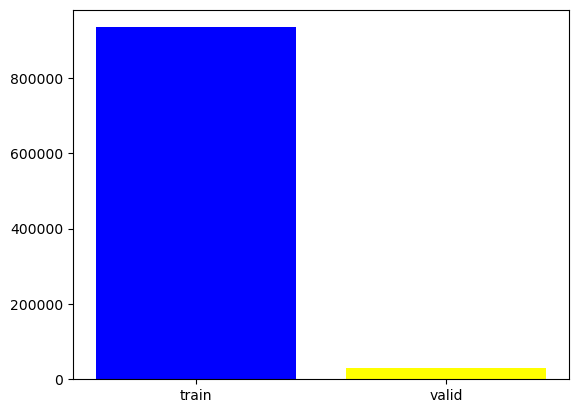

In [7]:
plt.bar(["train","valid"],[n_train_samples,n_valid_samples],color = ['blue', 'yellow'])

Now let's hear some audio files and see the corresponding text

In [8]:
root_path = "/kaggle/input/bengaliai-speech/train_mp3s"

for idx in range(1,len(df),99999):
    
    mp3_path = os.path.join(root_path,df['id'].iloc[idx])+ ".mp3"
    text = df['sentence'].iloc[idx]
    display(AudioSegment.from_file(mp3_path))
    print("Original transcription : ",text)


Original transcription :  ‡¶ï‡ßã‡¶® ‡¶Æ‡¶π‡¶æ‡¶® ‡¶∞‡¶æ‡¶∑‡ßç‡¶ü‡ßç‡¶∞‡ßá‡¶∞ ‡¶®‡¶æ‡¶ó‡¶∞‡¶ø‡¶ï ‡¶π‡¶§‡ßá ‡¶ö‡¶æ‡¶ì?


Original transcription :  ‡¶Ü‡¶™‡¶®‡¶æ‡¶∞‡¶æ ‡¶§‡¶æ‡¶ï‡ßá ‡¶Æ‡ßÅ‡¶ï‡ßá‡¶∂ ‡¶Æ‡ßá‡¶π‡¶∞‡¶æ ‡¶¨‡¶≤‡¶§‡ßá ‡¶™‡¶æ‡¶∞‡ßá‡¶®‡•§


Original transcription :  ‡¶è‡¶∞‡¶™‡¶∞ ‡¶ú‡ßÅ‡¶≤‡¶æ‡¶á‡ßü‡ßá‡¶∞ ‡¶§‡ßÉ‡¶§‡ßÄ‡ßü ‡¶∏‡¶™‡ßç‡¶§‡¶æ‡¶π‡ßá ‡¶π‡¶æ‡¶¨‡¶ø‡¶¨‡¶æ ‡¶Æ‡¶£‡ßç‡¶°‡¶≤ ‡¶¶‡ßç‡¶¨‡¶ø‡¶§‡ßÄ‡ßü ‡¶¶‡¶´‡¶æ ‡¶§‡¶¶‡¶®‡ßç‡¶§ ‡¶™‡ßç‡¶∞‡¶§‡¶ø‡¶¨‡ßá‡¶¶‡¶® ‡¶™‡¶æ‡¶†‡¶æ‡¶®‡•§


Original transcription :  ‡¶®‡¶æ‡¶∞‡ßÄ‡¶¶‡ßá‡¶∞ ‡¶∏‡¶Æ‡ßç‡¶Æ‡¶æ‡¶® ‡¶ï‡¶∞‡¶æ ‡¶∂‡ßá‡¶ñ‡¶æ‡¶∞ ‡¶ú‡¶®‡ßç‡¶Ø ‡¶Ü‡¶∞‡¶ø‡ßü‡¶æ‡¶®‡¶ï‡ßá ‡¶®‡¶æ‡¶®‡¶æ ‡¶™‡¶∞‡¶æ‡¶Æ‡¶∞‡ßç‡¶∂ ‡¶¶‡ßá‡¶® ‡¶¨‡¶≤‡ßá‡¶á ‡¶ú‡¶æ‡¶®‡¶ø‡ßü‡ßá‡¶õ‡¶ø‡¶≤‡ßá‡¶® ‡¶§‡¶ø‡¶®‡¶ø‡•§


Original transcription :  ‡¶ü‡ßá‡¶∏‡ßç‡¶ü ‡¶ï‡ßç‡¶∞‡¶ø‡¶ï‡ßá‡¶ü‡ßá ‡¶è‡¶ü‡¶æ ‡¶¨‡¶æ‡¶Ç‡¶≤‡¶æ‡¶¶‡ßá‡¶∂‡ßá‡¶∞ ‡¶ö‡¶§‡ßÅ‡¶∞‡ßç‡¶• ‡¶∏‡¶∞‡ßç‡¶¨‡ßã‡¶ö‡ßç‡¶ö ‡¶¨‡ßç‡¶Ø‡¶¨‡¶ß‡¶æ‡¶®‡ßá ‡¶π‡¶æ‡¶∞, ‡¶∂‡ßç‡¶∞‡ßÄ‡¶≤‡¶ô‡ßç‡¶ï‡¶æ‡¶∞ ‡¶¨‡¶ø‡¶™‡¶ï‡ßç‡¶∑‡ßá ‡¶∏‡¶∞‡ßç‡¶¨‡ßã‡¶ö‡ßç‡¶ö‡•§


Original transcription :  ‡¶Æ‡¶π‡¶æ‡¶ú‡ßç‡¶û‡¶æ‡¶®‡ßÄ ‡¶â‡¶¶‡ßç‡¶≠‡¶ø‡¶¶‡¶ó‡ßã‡¶∑‡ßç‡¶†‡ßÄ‡¶∞ ‡¶™‡¶∞‡ßÄ‡¶ï‡ßç‡¶∑‡¶æ‡¶∞ ‡¶è‡¶ï‡¶ü‡¶ø ‡¶¨‡¶∏‡ßç‡¶§‡ßÅ?


Original transcription :  ‡¶è‡¶∞‡¶™‡¶∞ ‡¶Ö‡¶ï‡ßç‡¶∏‡¶´‡ßã‡¶∞‡ßç‡¶° ‡¶¨‡¶ø‡¶∂‡ßç‡¶¨‡¶¨‡¶ø‡¶¶‡ßç‡¶Ø‡¶æ‡¶≤‡¶Ø‡¶º‡ßá‡¶∞ ‡¶ü‡ßç‡¶∞‡¶ø‡¶®‡¶ø‡¶ü‡¶ø ‡¶ï‡¶≤‡ßá‡¶ú‡ßá ‡¶™‡¶°‡¶º‡¶æ‡¶∂‡ßã‡¶®‡¶æ ‡¶ï‡¶∞‡ßá‡¶õ‡ßá‡¶®‡•§


Original transcription :  ‡¶ï‡¶æ‡¶π‡¶æ‡¶∞‡ßã ‡¶ï‡¶£‡ßç‡¶† ‡¶¶‡¶ø‡ßü‡¶æ ‡¶è‡¶ï‡¶ü‡¶ø ‡¶ï‡¶•‡¶æ ‡¶¨‡¶æ‡¶π‡¶ø‡¶∞ ‡¶π‡¶á‡¶≤ ‡¶®‡¶æ‡•§


Original transcription :  ‡¶π‡ßç‡¶Ø‡¶æ‡¶Å, ‡¶Ö‡ßç‡¶Ø‡¶æ‡¶∞‡¶®‡•§


Original transcription :  ‡¶¨‡¶Ç‡¶∂‡ßá‡¶∞ ‡¶∏‡¶Æ‡¶∏‡ßç‡¶§ ‡¶™‡ßç‡¶∞‡¶ú‡¶æ‡¶§‡¶ø‡¶∞ ‡¶ò‡¶®‡¶ø‡¶∑‡ßç‡¶†‡¶≠‡¶æ‡¶¨‡ßá ‡¶ú‡¶°‡¶º‡¶ø‡¶§ ‡¶¨‡¶ø‡¶∑‡¶Ø‡¶º‡¶ó‡ßÅ‡¶≤‡ßã ‡¶∏‡¶Æ‡ßç‡¶™‡¶∞‡ßç‡¶ï‡ßá ‡¶è‡¶¨‡¶Ç ‡¶ú‡ßá‡¶®‡ßá‡¶ü‡¶ø‡¶ï ‡¶®‡¶Æ‡ßÅ‡¶®‡¶æ ‡¶ú‡ßç‡¶û‡¶æ‡¶® ‡¶õ‡¶æ‡¶°‡¶º‡¶æ ‡¶è ‡¶™‡ßç‡¶∞‡¶ú‡¶æ‡¶§‡¶ø‡¶ü‡¶ø ‡¶∏‡¶®‡¶æ‡¶ï‡ßç‡¶§ ‡¶ï‡¶∞‡¶æ ‡¶ï‡¶†‡¶ø‡¶®‡•§


From these audios it's quite evident that the audios has a lot of varieties, in domains, in audio quality and other forms. Feel free to change the idxs and listen to different audios

For the test set, we'll have data from 17 domains. They have provided a sample for each of them. Let's hear some of them.

In [9]:
mp3_path = "/kaggle/input/bengaliai-speech/examples/Cartoon.wav"
print("Cartoon Audio")
display(AudioSegment.from_file(mp3_path))

mp3_path = "/kaggle/input/bengaliai-speech/examples/Poem Recital.wav"
print("Poem recital ")
display(AudioSegment.from_file(mp3_path))


Cartoon Audio


Poem recital 


This Cartoon is probably from the popular Cartoon show "Gopal Bhar" and the poem was written by the National Poet of Bangladesh, "Kazi Nazrul Islam"

<a id="4"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> üßêEDA on text sentencesüßê</center>


In [10]:
print(df.shape)
df.head()

(963636, 3)


id                                           sentence  split
0  000005f3362c                              ‡¶ì ‡¶¨‡¶≤‡ßá‡¶õ‡ßá ‡¶Ü‡¶™‡¶®‡¶æ‡¶∞ ‡¶†‡¶ø‡¶ï‡¶æ‡¶®‡¶æ!  train
1  00001dddd002                 ‡¶ï‡ßã‡¶® ‡¶Æ‡¶π‡¶æ‡¶® ‡¶∞‡¶æ‡¶∑‡ßç‡¶ü‡ßç‡¶∞‡ßá‡¶∞ ‡¶®‡¶æ‡¶ó‡¶∞‡¶ø‡¶ï ‡¶π‡¶§‡ßá ‡¶ö‡¶æ‡¶ì?  train
2  00001e0bc131     ‡¶Ü‡¶Æ‡¶ø ‡¶§‡ßã‡¶Æ‡¶æ‡¶∞ ‡¶ï‡¶∑‡ßç‡¶ü‡¶ü‡¶æ ‡¶¨‡ßÅ‡¶ù‡¶õ‡¶ø, ‡¶ï‡¶ø‡¶®‡ßç‡¶§‡ßÅ ‡¶è‡¶ü‡¶æ ‡¶∏‡¶†‡¶ø‡¶ï ‡¶™‡¶• ‡¶®‡¶æ‡•§  train
3  000024b3d810  ‡¶®‡¶æ‡¶ö ‡¶∂‡ßá‡¶∑ ‡¶π‡¶ì‡¶Ø‡¶º‡¶æ‡¶∞ ‡¶™‡¶∞ ‡¶∏‡¶ï‡¶≤‡ßá ‡¶∂‡¶∞‡ßÄ‡¶∞ ‡¶ß‡ßÅ‡¶Ø‡¶º‡ßá ‡¶è‡¶ï‡¶∏‡¶ô‡ßç‡¶ó‡ßá ‡¶≠‡ßã‡¶ú‡¶®...  train
4  000028220ab3                                ‡¶π‡ßÅ‡¶Æ‡¶Æ, ‡¶ì‡¶π ‡¶π‡ßá‡¶á, ‡¶¶‡ßá‡¶ñ‡ßã‡•§  train

A total of 963636 sentences. But how many unique sentences?

In [11]:
print("Total sentences :",len(df))
print("Total unique sentences : ",df.sentence.nunique())
print("Percentage of unique sentences ; ",df.sentence.nunique()/len(df))

Total sentences : 963636
Total unique sentences :  463264
Percentage of unique sentences ;  0.4807458417908837


That's interesting. 50% of the overall sentences are actually unique. So multiple of them has been repeated in the dataset. Let's look at the most frequent 10 sentences

In [12]:
print("Most frequent sentences in the dataset \n")
df.sentence.value_counts()[:10]

Most frequent sentences in the dataset 



‡¶§‡¶ø‡¶®‡¶ø ‡¶®‡¶æ‡¶ó‡¶™‡ßÅ‡¶∞‡ßá‡¶∞ ‡¶ú‡¶ø‡¶è‡¶∏ ‡¶ï‡¶≤‡ßá‡¶ú ‡¶Ö‡¶´ ‡¶ï‡¶Æ‡¶æ‡¶∞‡ßç‡¶∏ ‡¶Ö‡ßç‡¶Ø‡¶æ‡¶®‡ßç‡¶° ‡¶á‡¶ï‡ßã‡¶®‡¶Æ‡¶ø‡¶ï‡ßç‡¶∏ ‡¶•‡ßá‡¶ï‡ßá ‡¶∏‡ßç‡¶®‡¶æ‡¶§‡¶ï ‡¶°‡¶ø‡¶ó‡ßç‡¶∞‡¶ø ‡¶Ö‡¶∞‡ßç‡¶ú‡¶® ‡¶ï‡¶∞‡ßá‡¶õ‡¶ø‡¶≤‡ßá‡¶®‡•§    9
‡¶ó‡¶ø‡¶®‡¶ø ‡¶è‡¶™‡¶∞‡ßç‡¶Ø‡¶®‡ßç‡¶§ ‡¶è‡¶ï‡¶¨‡¶æ‡¶∞‡¶ì ‡¶´‡¶ø‡¶´‡¶æ ‡¶¨‡¶ø‡¶∂‡ßç‡¶¨‡¶ï‡¶æ‡¶™‡ßá ‡¶Ö‡¶Ç‡¶∂‡¶ó‡ßç‡¶∞‡¶π‡¶£ ‡¶ï‡¶∞‡¶§‡ßá ‡¶™‡¶æ‡¶∞‡ßá‡¶®‡¶ø‡•§                                 8
‡¶§‡¶¨‡ßá ‡¶∏‡ßç‡¶¨‡¶¶‡ßá‡¶∂‡ßÄ ‡¶Ü‡¶®‡ßç‡¶¶‡ßã‡¶≤‡¶®‡ßá ‡¶¨‡¶ø‡¶∂‡ßÉ‡¶ô‡ßç‡¶ñ‡¶≤‡¶æ ‡¶¶‡ßá‡¶ñ‡ßá ‡¶è‡¶ï ‡¶¨‡¶õ‡¶∞ ‡¶™‡¶∞ ‡¶§‡¶ø‡¶®‡¶ø ‡¶Ü‡¶¨‡¶æ‡¶∞ ‡¶™‡¶°‡¶º‡¶æ‡¶∂‡ßã‡¶®‡¶æ ‡¶∂‡ßÅ‡¶∞‡ßÅ ‡¶ï‡¶∞‡ßá‡¶®‡•§               8
‡¶è‡¶∏‡¶ø‡¶° ‡¶¨‡ßÉ‡¶∑‡ßç‡¶ü‡¶ø‡¶∞ ‡¶ï‡¶æ‡¶∞‡¶£‡ßá ‡¶ú‡ßÄ‡¶¨‡ßá‡¶∞ ‡¶ï‡ßç‡¶∑‡¶§‡¶ø ‡¶π‡¶§‡ßá ‡¶™‡¶æ‡¶∞‡ßá ‡¶¨‡¶æ ‡¶ú‡ßÄ‡¶¨ ‡¶Æ‡¶æ‡¶∞‡¶æ ‡¶Ø‡ßá‡¶§‡ßá ‡¶™‡¶æ‡¶∞‡ßá‡•§                            8
‡¶°‡¶æ‡¶®‡¶æ‡¶∞ ‡¶®‡¶ø‡¶Æ‡ßç‡¶®‡¶§‡¶≤ ‡¶™‡ßÅ‡¶∞‡ßÅ‡¶∑ ‡¶™‡ßç‡¶∞‡¶ï‡¶æ‡¶∞‡ßá‡¶∞ ‡¶∏‡¶π‡¶ø‡¶§ ‡¶∏‡¶æ‡¶Æ‡¶û‡ßç‡¶ú‡¶∏‡ßç‡¶Ø‡¶™‡ßÇ‡¶∞‡ßç‡¶£‡•§                   

**Let's look at the sentence length distribuition**

In [13]:
x = df.sentence.apply(lambda x: len(x))

(array([1.46812e+05, 3.01428e+05, 2.76002e+05, 1.89254e+05, 3.83470e+04,
        1.00420e+04, 1.62200e+03, 1.13000e+02, 1.10000e+01, 5.00000e+00]),
 array([  2. ,  25.1,  48.2,  71.3,  94.4, 117.5, 140.6, 163.7, 186.8,
        209.9, 233. ]),
 <BarContainer object of 10 artists>)

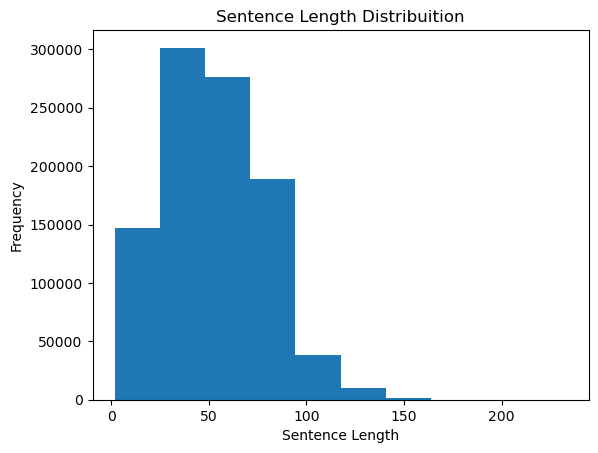

In [14]:
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Sentence Length Distribuition")
plt.hist(x)

Most of the sentences have length<=100

Let's look at the overall vocabulary size and the most frequent words


In [15]:
from tqdm import tqdm
vocab = {}
for sen in tqdm(df.sentence):
    for j in sen.split(" "):
        try:
            vocab[j]+=1
        except:
            vocab[j]=1
print("Total words in vocabulary : ",len(vocab))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 963636/963636 [00:06<00:00, 154306.72it/s]

Total words in vocabulary :  235761


So total 235761 words in vocabulary. That's huge. Let's look at the most frequent ones

In [16]:
sorted_vocab = sorted(vocab.items(),key = lambda kv:kv[1],reverse=True)
sorted_vocab[:30]

[('‡¶§‡¶ø‡¶®‡¶ø', 103223),
 ('‡¶è‡¶¨‡¶Ç', 55398),
 ('‡¶ì', 53633),
 ('‡¶è‡¶á', 52894),
 ('‡¶ï‡¶∞‡ßá', 51783),
 ('‡¶®‡¶æ‡•§', 49381),
 ('‡¶§‡¶æ‡¶∞', 48546),
 ('‡¶Ü‡¶Æ‡¶ø', 45334),
 ('‡¶•‡ßá‡¶ï‡ßá', 44279),
 ('‡¶è‡¶ï‡¶ü‡¶ø', 38195),
 ('‡¶Ü‡¶Æ‡¶æ‡¶∞', 37139),
 ('‡¶ú‡¶®‡ßç‡¶Ø', 36873),
 ('‡¶ï‡¶∞‡ßá‡¶®‡•§', 36044),
 ('‡¶ï‡¶∞‡¶æ', 32324),
 ('‡¶ï‡¶∞‡¶§‡ßá', 29019),
 ('‡¶ï‡¶ø‡¶®‡ßç‡¶§‡ßÅ', 26280),
 ('‡¶Ü‡¶∞', 23998),
 ('‡¶∏‡ßá', 22347),
 ('‡¶ï‡¶∞‡ßá‡•§', 21878),
 ('‡¶ï‡¶ø‡¶õ‡ßÅ', 20126),
 ('‡¶Æ‡¶ß‡ßç‡¶Ø‡ßá', 19481),
 ('‡¶§‡ßÅ‡¶Æ‡¶ø', 19305),
 ('‡¶è', 19270),
 ('‡¶è‡¶ü‡¶ø', 19177),
 ('‡¶ï‡¶•‡¶æ', 18849),
 ('‡¶®‡¶æ', 18595),
 ('‡¶∏‡¶ô‡ßç‡¶ó‡ßá', 18572),
 ('‡¶§‡¶æ‡¶Å‡¶∞', 18255),
 ('‡¶®‡¶ø‡ßü‡ßá', 17990),
 ('‡¶Ü‡¶Æ‡¶æ‡¶¶‡ßá‡¶∞', 17974)]

**So mostly bengali pronouns and common verbs.**

This is to remind you that this is the vocabulary of **train+validation**. You might wanna check how much **out of vocabulary** words does the validation set have. Let's check it.

In [17]:
def vocabulary(df):
    vocab = {}
    for sen in tqdm(df.sentence):
        for j in sen.split(" "):
            try:
                vocab[j]+=1
            except:
                vocab[j]=1
    return vocab

In [18]:
train = df[df["split"]=="train"]
val = df[df["split"]=="valid"]

train_vocab = vocabulary(train)
val_vocab = vocabulary(val)
print("Total words in train vocabulary : ",len(train_vocab))
print("Total words in validation vocabulary : ",len(val_vocab))

train_words = set([key for key,value in train_vocab.items()])
vocab_words = set([key for key,value in val_vocab.items()])

print("Total Out of vocabulary words : ",len(vocab_words-train_words))


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 29588/29588 [00:00<00:00, 179215.86it/s]


Total words in train vocabulary :  235448
Total words in validation vocabulary :  36695
Total Out of vocabulary words :  313


Okay not so much words.

Now let's look at the characters present.

In [19]:
chars = {}
for sen in tqdm(df.sentence):
    for j in sen:
        try:
            chars[j]+=1
        except:
            chars[j]=1
chars

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 963636/963636 [00:18<00:00, 52427.77it/s]


{'‡¶ì': 270350,
 ' ': 7151949,
 '‡¶¨': 1596697,
 '‡¶≤': 1218773,
 '‡ßá': 3743574,
 '‡¶õ': 531780,
 '‡¶Ü': 496257,
 '‡¶™': 1008454,
 '‡¶®': 2326578,
 '‡¶æ': 4384235,
 '‡¶∞': 3562802,
 '‡¶†': 92682,
 '‡¶ø': 2711057,
 '‡¶ï': 2065031,
 '!': 32013,
 '‡ßã': 534747,
 '‡¶Æ': 1243333,
 '‡¶π': 649499,
 '‡¶∑': 294522,
 '‡ßç': 2594672,
 '‡¶ü': 576753,
 '‡¶ó': 467760,
 '‡¶§': 1792703,
 '‡¶ö': 399051,
 '?': 63923,
 '‡ßÅ': 787146,
 '‡¶ù': 26251,
 ',': 282795,
 '‡¶è': 487046,
 '‡¶∏': 1215080,
 '‡¶•': 321413,
 '‡•§': 866069,
 '‡¶∂': 532162,
 '‡¶Ø': 993494,
 '‡¶º': 326417,
 '‡ßÄ': 374260,
 '‡¶ß': 281460,
 '‡¶ô': 64560,
 '‡¶≠': 304264,
 '‡¶ú': 533592,
 '‡¶á': 475800,
 '‡¶¶': 867695,
 '‡¶ñ': 303622,
 '‡¶´': 125787,
 '‡¶Ç': 194042,
 '‡¶â': 134682,
 '‡¶£': 194144,
 '‡¶Ö': 287349,
 '‡¶Å': 109928,
 '‡ßú': 105453,
 '‡ßü': 574923,
 '‡¶¢': 13539,
 '‡¶°': 163943,
 '‡ßà': 32389,
 '‡ßÉ': 80533,
 '-': 75769,
 '‡ßÇ': 95514,
 '‡¶ò': 63956,
 '‡¶û': 45279,
 '‚Äò': 1598,
 '‚Äô': 2703,
 '"': 16329,
 '‚Äî': 2104,
 '‡ßå': 2

In [20]:
print("Total characters :",len(chars))

Total characters : 87


[(' ', 7151949), ('‡¶æ', 4384235), ('‡ßá', 3743574), ('‡¶∞', 3562802), ('‡¶ø', 2711057), ('‡ßç', 2594672), ('‡¶®', 2326578), ('‡¶ï', 2065031), ('‡¶§', 1792703), ('‡¶¨', 1596697)]


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2494 (\N{BENGALI VOWEL SIGN AA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2503 (\N{BENGALI VOWEL SIGN E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/cor

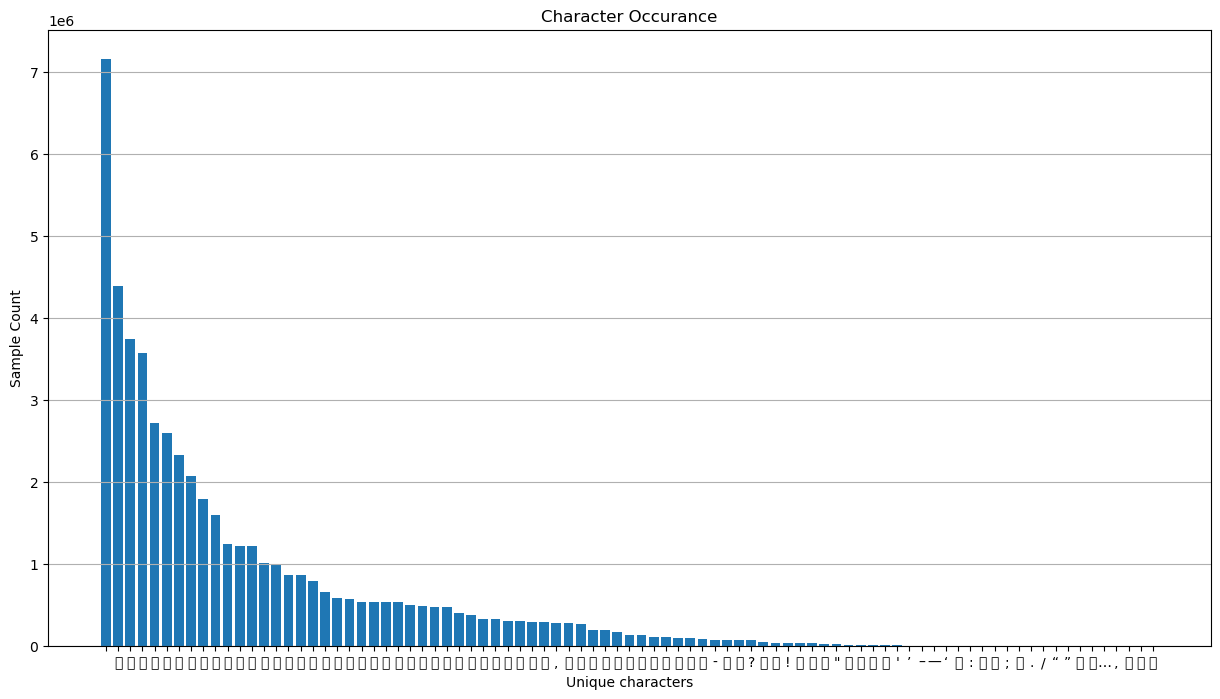

In [21]:
sorted_chars = sorted(chars.items(),key = lambda x:x[1],reverse = True)
print(sorted_chars[:10])
sorted_chars = dict(sorted_chars)
plt.figure(figsize=(15,8))
plt.title('Character Occurance')
plt.bar(sorted_chars.keys(),sorted_chars.values())
plt.xlabel('Unique characters')
plt.ylabel('Sample Count')
plt.grid(axis='y')
plt.show()

<a id="5"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> üîçText Normalization üîç</center>


At this point you might ask what is text normalization and why do we need it here? Well, this is one of the challenges in bangla. It has so manyyy characters whereas English has only 26 characters. As a result a word could have different forms.

For example, look at this pair :

**‡¶®‡¶ø‡ßü‡ßá == ‡¶®‡¶ø‡¶Ø‡¶º‡ßá**

**‡¶π‡ßü‡ßá == ‡¶π‡¶Ø‡¶º‡ßá**

**‡¶ï‡¶•‡¶æ‡ßü == ‡¶ï‡¶•‡¶æ‡¶Ø‡¶º**

**‡¶ö‡¶ø‡ßú‡ßá == ‡¶ö‡¶ø‡¶°‡¶º‡ßá**


Don't they look absolutely same? Well let's see.

In [22]:
print("‡¶®‡¶ø‡ßü‡ßá" == "‡¶®‡¶ø‡¶Ø‡¶º‡ßá")
print("‡¶π‡ßü‡ßá" == "‡¶π‡¶Ø‡¶º‡ßá")
print("‡¶ö‡¶ø‡ßú‡ßá"=="‡¶ö‡¶ø‡¶°‡¶º‡ßá")


False
False
False


**Wait what? Why the computer is saying they aren't equal? They look absolutely identitcal.**

In [23]:
print(list("‡¶®‡¶ø‡ßü‡ßá"))
print(list("‡¶®‡¶ø‡¶Ø‡¶º‡ßá"))

['‡¶®', '‡¶ø', '‡ßü', '‡ßá']
['‡¶®', '‡¶ø', '‡¶Ø', '‡¶º', '‡ßá']


In [24]:
print(list("‡¶ö‡¶ø‡ßú‡ßá"))
print(list("‡¶ö‡¶ø‡¶°‡¶º‡ßá"))

['‡¶ö', '‡¶ø', '‡ßú', '‡ßá']
['‡¶ö', '‡¶ø', '‡¶°', '‡¶º', '‡ßá']


Do you get it now? Although they look identical, they both have unequal amount of characters.

**"‡¶®‡¶ø‡¶Ø‡¶º‡ßá"** has an extra character **"'‡¶º'"**

Well here's the thing. The character "‡ßü" you are seeing can be written in two ways. 

**"‡ßü" -> '‡ßü' (First word)**

**"‡ßü" ->  '‡¶Ø'+ '‡¶º'**

**This '‡¶º' symbol is called Nukta, the characters having dots under them ("‡ßü",'‡ßú' etc.) can have it , it some notation they might not. So if the dataset contain both forms, the metric will count them as unequal words and thus add an error.**

Also think, you're confused seeing these words. The model will also get confused seeing two representations of the same word.

How to avoid this problem? Well normalizer to the rescue. We want to bring all the words in a canonical form. Normalizer will do that for us.

We'll be using [this normalizer](https://github.com/csebuetnlp/normalizer) for this Notebook. There are several others for bangla.

Let's first install it

In [25]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-0wp52szk
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-0wp52szk
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... - \ done
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 185.0/185.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 64.2/64.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6885 sha256=61a69a67ac8437cecfd3e59dbddcb3f993460edc93251efc482893ecdb81f84c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6wiy8m3f/wheels/2e

How to use? We can use it on the whole sentence

In [26]:
from normalizer import normalize
sentence = "‡¶è‡¶Æ‡¶®‡¶ï‡¶ø ‡¶â‡¶ï‡ßÅ‡¶® ‡¶ò‡¶∞‡¶¨‡¶æ‡ßú‡¶ø ‡¶ì ‡¶ñ‡¶æ‡¶¶‡ßç‡¶Ø-‡¶∏‡¶Æ‡ßç‡¶≠‡¶æ‡¶∞‡ßá‡¶∞ ‡¶â‡¶™‡¶∞ ‡¶õ‡ßú‡¶ø‡ßü‡ßá ‡¶™‡ßú‡¶§‡ßá ‡¶≤‡¶æ‡¶ó‡¶≤‡•§"
normalized = normalize(sentence)
print(normalized)
print(normalize==sentence)

‡¶è‡¶Æ‡¶®‡¶ï‡¶ø ‡¶â‡¶ï‡ßÅ‡¶® ‡¶ò‡¶∞‡¶¨‡¶æ‡¶°‡¶º‡¶ø ‡¶ì ‡¶ñ‡¶æ‡¶¶‡ßç‡¶Ø-‡¶∏‡¶Æ‡ßç‡¶≠‡¶æ‡¶∞‡ßá‡¶∞ ‡¶â‡¶™‡¶∞ ‡¶õ‡¶°‡¶º‡¶ø‡¶Ø‡¶º‡ßá ‡¶™‡¶°‡¶º‡¶§‡ßá ‡¶≤‡¶æ‡¶ó‡¶≤‡•§
False


Or we can use it on word level

In [27]:
normalize("‡¶®‡¶ø‡ßü‡ßá")==normalize("‡¶®‡¶ø‡¶Ø‡¶º‡ßá")

True

See! The problem is now gone.


<a id="8"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> Intent of texts</center>


We can find out the intents of the text sentences. This might help out to find the most suitable punctuations for each sentence. Let's first see which type of punctuations are present in the sentences

In [28]:
base_puncs = ['!','?','‡•§']

puncs = {}

for i in tqdm(train.sentence.tolist()):
    last = i[-1]
    
    if last not in base_puncs:
        last = "others"
        
    try:
        puncs[last]+=1
    except:
        puncs[last] = 1


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 934048/934048 [00:01<00:00, 804358.85it/s]


In [29]:
puncs

{'!': 31589, '?': 63632, '‡•§': 836373, 'others': 2454}

This can be categorized in 4 types:
> **'‡•§'** -> **statements**

> **'!'** --> Exclamation

> **?** --> Question

> **Others** -> Neutral/Wrong annotation/Incompleted sentence

**Let's look at the validation set**

In [30]:
base_puncs = ['!','?','‡•§']

puncs = {}

for i in tqdm(val.sentence.tolist()):
    last = i[-1]
    
    if last not in base_puncs:
        last = "others"
        
    try:
        puncs[last]+=1
    except:
        puncs[last] = 1
puncs


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 29588/29588 [00:00<00:00, 660945.27it/s]


{'‡•§': 29116, '?': 184, 'others': 214, '!': 74}

<a id="6"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> üñãÔ∏è Evaluation Metric : WER üñãÔ∏è</center>

WER stands for Word Error Rate. Word error rate is a common metric of the performance of a speech recognition or machine translation system. (from wiki) 

 ~~~
 It measures the percentage of words that are incorrectly recognized or transcribed compared to a reference or ground truth.

The formula for calculating WER is as follows:

WER = (S + D + I) / N

where:
S = the number of word substitutions (words in the reference that are replaced with incorrect words in the recognition)
D = the number of word deletions (words in the reference that are not present in the recognition)
I = the number of word insertions (additional words inserted in the recognition that are not present in the reference)
N = the total number of words in the reference

To calculate WER, the ASR or OCR system's output is compared to a known and correct reference text. Any differences in words, including substitutions, deletions, and insertions, are counted and divided by the total number of words in the reference.

WER is typically expressed as a percentage, where lower values indicate better performance. For example, a WER of 10% means that 10% of the words in the recognized output are incorrect or differ from the reference. (From my good friend ChatGPT)
~~~

Now how to calculate? We'll use jiwer to calculate WER

In [31]:
df['sentence'].tolist()[:20]

['‡¶ì ‡¶¨‡¶≤‡ßá‡¶õ‡ßá ‡¶Ü‡¶™‡¶®‡¶æ‡¶∞ ‡¶†‡¶ø‡¶ï‡¶æ‡¶®‡¶æ!',
 '‡¶ï‡ßã‡¶® ‡¶Æ‡¶π‡¶æ‡¶® ‡¶∞‡¶æ‡¶∑‡ßç‡¶ü‡ßç‡¶∞‡ßá‡¶∞ ‡¶®‡¶æ‡¶ó‡¶∞‡¶ø‡¶ï ‡¶π‡¶§‡ßá ‡¶ö‡¶æ‡¶ì?',
 '‡¶Ü‡¶Æ‡¶ø ‡¶§‡ßã‡¶Æ‡¶æ‡¶∞ ‡¶ï‡¶∑‡ßç‡¶ü‡¶ü‡¶æ ‡¶¨‡ßÅ‡¶ù‡¶õ‡¶ø, ‡¶ï‡¶ø‡¶®‡ßç‡¶§‡ßÅ ‡¶è‡¶ü‡¶æ ‡¶∏‡¶†‡¶ø‡¶ï ‡¶™‡¶• ‡¶®‡¶æ‡•§',
 '‡¶®‡¶æ‡¶ö ‡¶∂‡ßá‡¶∑ ‡¶π‡¶ì‡¶Ø‡¶º‡¶æ‡¶∞ ‡¶™‡¶∞ ‡¶∏‡¶ï‡¶≤‡ßá ‡¶∂‡¶∞‡ßÄ‡¶∞ ‡¶ß‡ßÅ‡¶Ø‡¶º‡ßá ‡¶è‡¶ï‡¶∏‡¶ô‡ßç‡¶ó‡ßá ‡¶≠‡ßã‡¶ú‡¶® ‡¶ï‡¶∞‡ßá‡¶®‡•§',
 '‡¶π‡ßÅ‡¶Æ‡¶Æ, ‡¶ì‡¶π ‡¶π‡ßá‡¶á, ‡¶¶‡ßá‡¶ñ‡ßã‡•§',
 '‡¶ï‡ßç‡¶Ø‡¶æ‡¶™‡ßç‡¶ü‡ßá‡¶®, ‡¶Ü‡¶Æ‡¶∞‡¶æ ‡¶¨‡ßç‡¶≤‡¶æ‡¶∏‡ßç‡¶ü‡¶æ‡¶∞‡¶ü‡¶æ‡¶ï‡ßá ‡¶†‡¶ø‡¶ï ‡¶ß‡¶∞‡ßá ‡¶´‡ßá‡¶≤‡¶¨‡ßã‡•§',
 '‡¶®‡¶æ‡¶ü‡¶ï, ‡¶∏‡¶æ‡¶Ç‡¶¨‡¶æ‡¶¶‡¶ø‡¶ï‡¶§‡¶æ, ‡¶∂‡¶ø‡¶ï‡ßç‡¶∑‡¶æ‡¶∞ ‡¶â‡¶™‡¶∞‡ßá ‡¶§‡¶æ‡¶∞ ‡¶â‡¶ö‡ßç‡¶ö‡¶§‡¶∞ ‡¶™‡ßç‡¶∞‡¶∂‡¶ø‡¶ï‡ßç‡¶∑‡¶£ ‡¶∞‡¶Ø‡¶º‡ßá‡¶õ‡ßá ‡¶è‡¶¨‡¶Ç ‡¶§‡¶ø‡¶®‡¶ø ‡¶è ‡¶∏‡¶Æ‡ßç‡¶™‡¶∞‡ßç‡¶ï‡¶ø‡¶§ ‡¶Ö‡¶®‡ßá‡¶ï ‡¶ï‡¶∞‡ßç‡¶Æ‡¶∂‡¶æ‡¶≤‡¶æ ‡¶¨‡¶æ ‡¶∏‡ßá‡¶Æ‡¶ø‡¶®‡¶æ‡¶∞ ‡¶™‡¶∞‡¶ø‡¶ö‡¶æ‡¶≤‡¶®‡¶æ ‡¶ï‡¶∞‡¶õ‡ßá‡¶®‡•§',
 '‡¶ó‡ßÅ‡¶≤‡¶ø‡¶¨‡¶ø‡¶¶‡ßç‡¶ß ‡¶á‡¶Æ‡¶æ‡¶Æ ‡¶∂‡¶æ‡¶π‡¶ø‡¶®‡ßÅ‡¶∞ ‡¶∞‡¶π‡¶

In [32]:
!pip install jiwer

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.2/2.2 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: rapidfuzz
    Found existing installation: rapidfuzz 3.1.1
    Uninstalling rapidfuzz-3.1.1:
      Successfully uninstalled rapidfuzz-3.1.1


In [33]:
from jiwer import wer

ground_truth =  '‡¶Ü‡¶ú ‡¶™‡¶∞‡ßç‡¶Ø‡¶®‡ßç‡¶§ ‡¶ï‡ßá‡¶â‡¶á ‡¶ï‡¶æ‡¶∞‡ßç‡¶§‡¶ø‡¶ï‡ßá‡ßü‡¶æ‡¶®‡¶ï‡ßá ‡¶∏‡¶®‡ßç‡¶¶‡ßá‡¶π ‡¶ï‡¶ø‡¶Ç‡¶¨‡¶æ ‡¶™‡ßç‡¶∞‡¶∂‡ßç‡¶®‡¶¨‡¶ø‡¶¶‡ßç‡¶ß ‡¶ï‡¶∞‡ßá‡¶®‡¶ø‡•§'
prediction = normalize(ground_truth)
print("Ground Truth : ",ground_truth)
print("prediction : ",prediction)

print("Word Error Rate : ",wer(ground_truth,prediction))


Ground Truth :  ‡¶Ü‡¶ú ‡¶™‡¶∞‡ßç‡¶Ø‡¶®‡ßç‡¶§ ‡¶ï‡ßá‡¶â‡¶á ‡¶ï‡¶æ‡¶∞‡ßç‡¶§‡¶ø‡¶ï‡ßá‡ßü‡¶æ‡¶®‡¶ï‡ßá ‡¶∏‡¶®‡ßç‡¶¶‡ßá‡¶π ‡¶ï‡¶ø‡¶Ç‡¶¨‡¶æ ‡¶™‡ßç‡¶∞‡¶∂‡ßç‡¶®‡¶¨‡¶ø‡¶¶‡ßç‡¶ß ‡¶ï‡¶∞‡ßá‡¶®‡¶ø‡•§
prediction :  ‡¶Ü‡¶ú ‡¶™‡¶∞‡ßç‡¶Ø‡¶®‡ßç‡¶§ ‡¶ï‡ßá‡¶â‡¶á ‡¶ï‡¶æ‡¶∞‡ßç‡¶§‡¶ø‡¶ï‡ßá‡¶Ø‡¶º‡¶æ‡¶®‡¶ï‡ßá ‡¶∏‡¶®‡ßç‡¶¶‡ßá‡¶π ‡¶ï‡¶ø‡¶Ç‡¶¨‡¶æ ‡¶™‡ßç‡¶∞‡¶∂‡ßç‡¶®‡¶¨‡¶ø‡¶¶‡ßç‡¶ß ‡¶ï‡¶∞‡ßá‡¶®‡¶ø‡•§
Word Error Rate :  0.125


In [34]:
ground_truth =  '‡¶ï‡ßç‡¶Ø‡¶æ‡¶™‡ßç‡¶ü‡ßá‡¶®, ‡¶Ü‡¶Æ‡¶∞‡¶æ ‡¶¨‡ßç‡¶≤‡¶æ‡¶∏‡ßç‡¶ü‡¶æ‡¶∞‡¶ü‡¶æ‡¶ï‡ßá ‡¶†‡¶ø‡¶ï ‡¶ß‡¶∞‡ßá ‡¶´‡ßá‡¶≤‡¶¨‡ßã‡•§'
prediction = '‡¶ï‡ßç‡¶Ø‡¶æ‡¶™‡ßç‡¶ü‡ßá‡¶®, ‡¶Ü‡¶Æ‡¶∞‡¶æ ‡¶≠‡ßç‡¶≤‡¶æ‡¶ö ‡¶∏‡ßç‡¶ü‡¶æ‡¶∞ ‡¶ü‡¶æ‡¶ï‡ßá ‡¶†‡¶ø‡¶ï ‡¶ß‡¶∞‡¶ø‡¶§‡¶∞‡ßç‡¶≠‡¶¨‡•§'
print("Ground Truth : ",ground_truth)
print("prediction : ",prediction)

print("Word Error Rate : ",wer(ground_truth,prediction))

Ground Truth :  ‡¶ï‡ßç‡¶Ø‡¶æ‡¶™‡ßç‡¶ü‡ßá‡¶®, ‡¶Ü‡¶Æ‡¶∞‡¶æ ‡¶¨‡ßç‡¶≤‡¶æ‡¶∏‡ßç‡¶ü‡¶æ‡¶∞‡¶ü‡¶æ‡¶ï‡ßá ‡¶†‡¶ø‡¶ï ‡¶ß‡¶∞‡ßá ‡¶´‡ßá‡¶≤‡¶¨‡ßã‡•§
prediction :  ‡¶ï‡ßç‡¶Ø‡¶æ‡¶™‡ßç‡¶ü‡ßá‡¶®, ‡¶Ü‡¶Æ‡¶∞‡¶æ ‡¶≠‡ßç‡¶≤‡¶æ‡¶ö ‡¶∏‡ßç‡¶ü‡¶æ‡¶∞ ‡¶ü‡¶æ‡¶ï‡ßá ‡¶†‡¶ø‡¶ï ‡¶ß‡¶∞‡¶ø‡¶§‡¶∞‡ßç‡¶≠‡¶¨‡•§
Word Error Rate :  0.8333333333333334


<a id="7"></a>
<div class="alert alert-block alert-info" style="padding:25px; line-height: 1.7em; font-family: Verdana;">
    <center style="font-family: consolas; font-size: 32px; font-weight: bold; color:purple"> ‚¨áÔ∏èAudio EDA‚¨áÔ∏è</center>


Let's first look at the audio durations and sampling rates. We'll use mutagen since it's faster.

In [35]:
!pip install mutagen

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 193.6/193.6 kB 5.7 MB/s eta 0:00:00


In [36]:
import os
import glob
import concurrent.futures
from mutagen.mp3 import MP3

def process_mp3_file(mp3_file):
    try:
        audio = MP3(mp3_file)
        duration = audio.info.length
        sample_rate = audio.info.sample_rate
        return mp3_file, duration, sample_rate
    except Exception as e:
        print(f"Error processing {mp3_file}: {e}")
        return mp3_file, None, None

def process_mp3_files_in_batch(mp3_files):
    durs = []
    srs = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_mp3_file, mp3_file) for mp3_file in mp3_files]
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            durs.append(result[1])
            srs.append(result[2])
    return durs,srs

def durations(mp3_files_directory):
    # Get a list of all MP3 files in the directory
    mp3_files = glob.glob(os.path.join(mp3_files_directory, "*.mp3"))

    # Split the list of files into batches for processing
    batch_size = 1000
    file_batches = [mp3_files[i:i + batch_size] for i in tqdm(range(0, len(mp3_files), batch_size))]

    durs = []
    srs = []
    for batch in tqdm(file_batches):
        dur,sr = process_mp3_files_in_batch(batch)
        durs.extend(dur)
        srs.extend(sr)
    return durs,srs

In [37]:
train_path = "/kaggle/input/bengaliai-speech/train_mp3s"
durs,srs = durations(train_path)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 964/964 [22:13<00:00,  1.38s/it]


(array([2.89287e+05, 3.72442e+05, 2.20388e+05, 7.40500e+04, 7.43100e+03,
        7.00000e+00, 2.00000e+00, 5.00000e+00, 1.50000e+01, 9.00000e+00]),
 array([ 0.54 ,  2.916,  5.292,  7.668, 10.044, 12.42 , 14.796, 17.172,
        19.548, 21.924, 24.3  ]),
 <BarContainer object of 10 artists>)

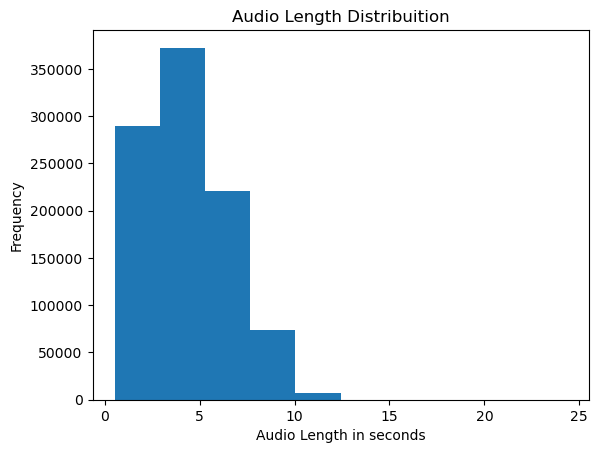

In [38]:
plt.xlabel("Audio Length in seconds")
plt.ylabel("Frequency")
plt.title("Audio Length Distribuition")
plt.hist(durs)

Nice! Staircase.

For sampling rate :

In [39]:
set(srs)

{32000}

So only one value. All sampled at 32k.

(array([     0.,      0.,      0.,      0.,      0., 963636.,      0.,
             0.,      0.,      0.]),
 array([31999.5, 31999.6, 31999.7, 31999.8, 31999.9, 32000. , 32000.1,
        32000.2, 32000.3, 32000.4, 32000.5]),
 <BarContainer object of 10 artists>)

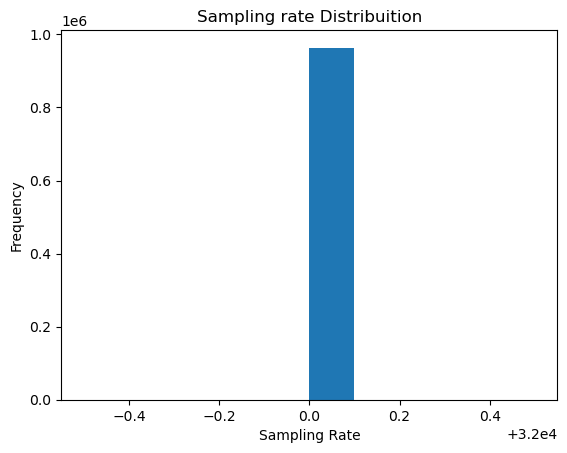

In [40]:
plt.xlabel("Sampling Rate")
plt.ylabel("Frequency")
plt.title("Sampling rate Distribuition")
plt.hist(srs)

In [41]:
#To DO : Audio length, sampling rate analysis